# ENCM 509 - Face Detection

In [46]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install lxml

### Load Data
Dataset from : https://www.kaggle.com/datasets/trainingdatapro/face-detection-photos-and-labels/data

We've narrowed down the image dataset to 9 images, which cover a wide range of aspects that could interfere with face detection, such as hair, glasses, and lighting.


In [47]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

csv_path = "data/face_detection.csv"
df = pd.read_csv(csv_path)

# Read the image paths
image_paths = df["image"]
label_paths = df["label"]

full_paths = [os.path.join("data", img_path) for img_path in image_paths]
full_label_paths = [os.path.join("data", lbl_path) for lbl_path in label_paths]


In [48]:
import xml.etree.ElementTree as ET
import os

xml_file = "data/corrected.xml"

tree = ET.parse(xml_file)
root = tree.getroot()
# Extract just the filenames from full_paths
image_filenames = [os.path.basename(path) for path in full_paths]

truth_data = []
for image in root.findall("image"):
    img_name = image.get("name")
    
    # Check if the image name is in the list of filenames
    if os.path.basename(img_name) in image_filenames:
        width = int(image.get("width"))
        height = int(image.get("height"))
        
        for box in image.findall("box"):
            xtl = float(box.get("xtl"))
            ytl = float(box.get("ytl"))
            xbr = float(box.get("xbr"))
            ybr = float(box.get("ybr"))
            
            truth_data.append({
                "name": img_name,
                "bbox": (xtl, ytl, xbr, ybr),
                "width": width,
                "height": height
            })

# Print the filtered truth data
for img in truth_data:
    print(img)

{'name': 'images/1.jpg', 'bbox': (610.53, 1274.55, 1716.9, 2746.81), 'width': 2448, 'height': 3264}
{'name': 'images/3.jpg', 'bbox': (592.29, 766.1, 1232.29, 1756.5), 'width': 1936, 'height': 2592}
{'name': 'images/4.jpg', 'bbox': (284.7, 868.5, 1391.7, 2522.29), 'width': 1980, 'height': 2640}
{'name': 'images/9.jpg', 'bbox': (533.68, 455.8, 1682.12, 2024.4), 'width': 2448, 'height': 3264}
{'name': 'images/10.jpg', 'bbox': (707.24, 955.5, 1642.69, 2453.6), 'width': 2448, 'height': 3264}
{'name': 'images/12.jpg', 'bbox': (940.76, 785.4, 1980.36, 2306.17), 'width': 2448, 'height': 3264}
{'name': 'images/23.jpg', 'bbox': (1196.3, 1296.2, 2423.81, 3002.86), 'width': 3456, 'height': 4608}
{'name': 'images/28.jpg', 'bbox': (775.63, 459.9, 1858.44, 2134.2), 'width': 2448, 'height': 3264}
{'name': 'images/43.jpg', 'bbox': (855.38, 444.2, 1759.1, 1805.74), 'width': 2320, 'height': 3088}


In [49]:
# Load and convert images to grayscale
grayscale_images = []
for full_path in full_paths:
    image = cv2.imread(full_path)
    if image is None:
        print(f"Error loading image: {full_path}")
        continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    grayscale_images.append(gray)

### Helper Functions

IOU calculation code adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [50]:
def calculate_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [51]:
def display_images_in_grid(images, names, images_per_row=5):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    plt.figure(figsize=(15, num_rows * 3))
    for i, (img, name) in enumerate(zip(images, names)):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(name, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [56]:
def calc_metrics_from_iou_threshold(thresholdValue, iouScores):
    TP = 0
    FN = 0
    FP = 0

    for iou_list in iouScores:
        if not iou_list:
            FN += 1
        else:
            for iou in iou_list:
                if iou >= thresholdValue:
                    TP += 1
                else:
                    FP += 1
    
    return TP, FP, FN


### Original Haar Cascades
Code adapted from https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection

In [ ]:
import cv2

def haar_cascades(images, truth_data, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)):
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    
    results = []
    processed_images = []
    image_names = []
    
    for image, truth in zip(images, truth_data):
        # Ensure the image is in color if it's grayscale
        if len(image.shape) == 2:
            image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_copy = image.copy()
        
        detected_faces = face_classifier.detectMultiScale(image_copy, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize)
        
        iou_list = []
        
        # Draw the original bounding box in green
        x1, y1, x2, y2 = map(int, truth['bbox'])
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 5)
        
        for (x, y, w, h) in detected_faces:
            detected_box = (x, y, x + w, y + h)
            iou = calculate_iou(detected_box, truth['bbox'])
            iou_list.append(iou)
            
            # Draw detected bounding box in red
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 5)
        
        results.append({
            "Image": truth['name'],
            "ScaleFactor": scaleFactor,
            "MinNeighbors": minNeighbors,
            "IoU": iou_list,
        })
        
        img_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        processed_images.append(img_rgb)
        image_names.append(truth['name'])
    
    return results, processed_images, image_names

           Image                                                 IoU
0   images/1.jpg                                [0.7602199032046598]
1   images/3.jpg                 [0.6549672922591074, 0.0, 0.0, 0.0]
2   images/4.jpg                                [0.6900237156190328]
3   images/9.jpg  [0.0, 0.6952350518324195, 0.0, 0.0, 0.0, 0.0, 0.0]
4  images/10.jpg                      [0.6432313648880684, 0.0, 0.0]
5  images/12.jpg                      [0.6994406810823207, 0.0, 0.0]
6  images/23.jpg                                [0.6703852277190135]
7  images/28.jpg                                [0.6684553831735386]
8  images/43.jpg            [0.6869927876067429, 0.0, 0.0, 0.0, 0.0]


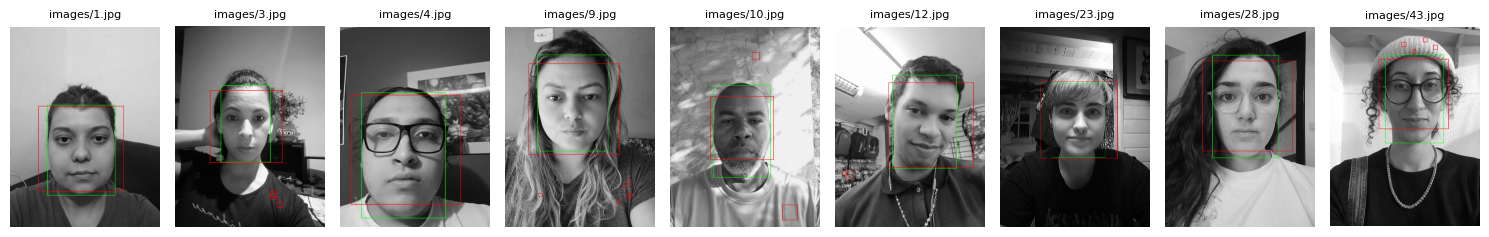

Scale Factor: 1.1, Min Neighbors: 4
True Positives: 9, False Positives: 17, False Negatives: 0


In [57]:
#Keeping scaleFactor=1.1
results_1, processed_images_1, image_names  = haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=4)

df_results_1 = pd.DataFrame(results_1)

print(df_results_1[['Image', 'IoU']])
display_images_in_grid(processed_images_1, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_1['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

           Image                        IoU
0   images/1.jpg       [0.7602199032046598]
1   images/3.jpg       [0.6549672922591074]
2   images/4.jpg       [0.6900237156190328]
3   images/9.jpg  [0.6952350518324195, 0.0]
4  images/10.jpg  [0.6432313648880684, 0.0]
5  images/12.jpg  [0.6994406810823207, 0.0]
6  images/23.jpg       [0.6703852277190135]
7  images/28.jpg       [0.6684553831735386]
8  images/43.jpg                      [0.0]


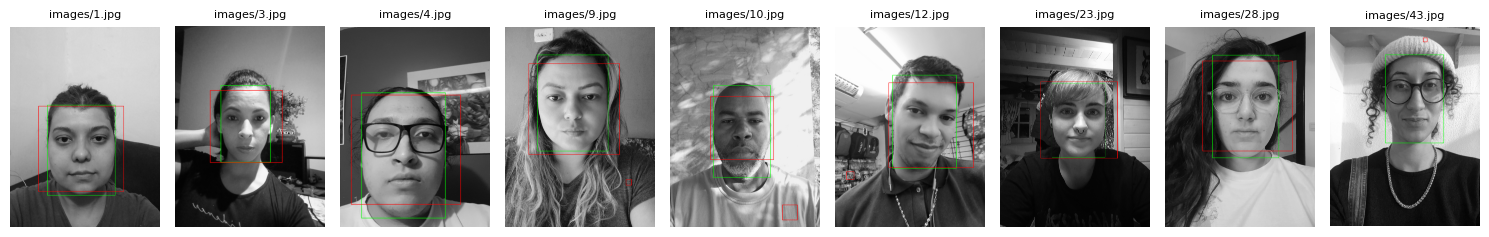

Scale Factor: 1.1, Min Neighbors: 10
True Positives: 8, False Positives: 4, False Negatives: 0


In [58]:
#Keeping scaleFactor=1.1
results_2, processed_images_2, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=1.1, minNeighbors=10)
df_results_2 = pd.DataFrame(results_2)

print(df_results_2[['Image', 'IoU']])
display_images_in_grid(processed_images_2, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_2['IoU'])
print("Scale Factor: 1.1, Min Neighbors: 10")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

           Image                   IoU
0   images/1.jpg  [0.7607821221321016]
1   images/3.jpg  [0.6603094786792205]
2   images/4.jpg                    []
3   images/9.jpg  [0.7382579775124012]
4  images/10.jpg  [0.6081752527409444]
5  images/12.jpg  [0.6994406810823207]
6  images/23.jpg  [0.4863031789813879]
7  images/28.jpg  [0.6722679354872927]
8  images/43.jpg                    []


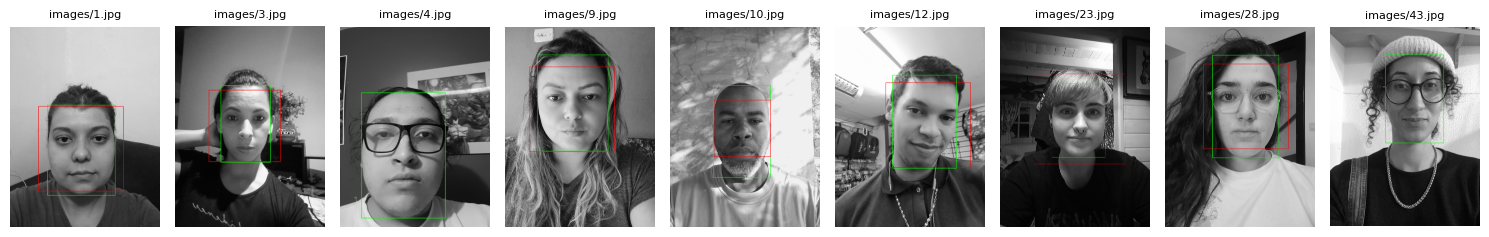

Scale Factor: 1.5, Min Neighbors: 4
True Positives: 6, False Positives: 1, False Negatives: 2


In [68]:
#Keeping minNeighbors=4
results_3, processed_images_3, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=1.5, minNeighbors=4)
df_results_3 = pd.DataFrame(results_3)

print(df_results_3[['Image', 'IoU']])
display_images_in_grid(processed_images_3, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_3['IoU'])
print("Scale Factor: 1.5, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

           Image                    IoU
0   images/1.jpg                     []
1   images/3.jpg   [0.6131720829329889]
2   images/4.jpg                     []
3   images/9.jpg             [0.0, 0.0]
4  images/10.jpg   [0.6346354162052144]
5  images/12.jpg                     []
6  images/23.jpg  [0.49484297408102546]
7  images/28.jpg                     []
8  images/43.jpg  [0.17216654114626645]


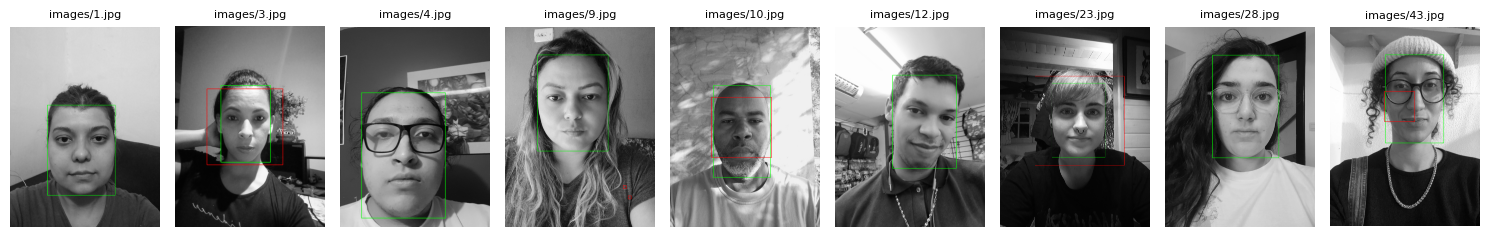

Scale Factor: 2.1, Min Neighbors: 4
True Positives: 2, False Positives: 4, False Negatives: 4


In [69]:
#Keeping minNeighbors=4
results_4, processed_images_4, image_names = haar_cascades(grayscale_images, truth_data, scaleFactor=2.1, minNeighbors=4)
df_results_4 = pd.DataFrame(results_4)

print(df_results_4[['Image', 'IoU']])
display_images_in_grid(processed_images_4, image_names, images_per_row=9)
TP, FP, FN = calc_metrics_from_iou_threshold(0.5, df_results_4['IoU'])
print("Scale Factor: 2.1, Min Neighbors: 4")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")